In [1]:
import torch
import numpy as np
import random
import torchvision
from torchvision import datasets, transforms


c:\Conda\envs\PyTorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Nie można odnaleźć określonej procedury'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


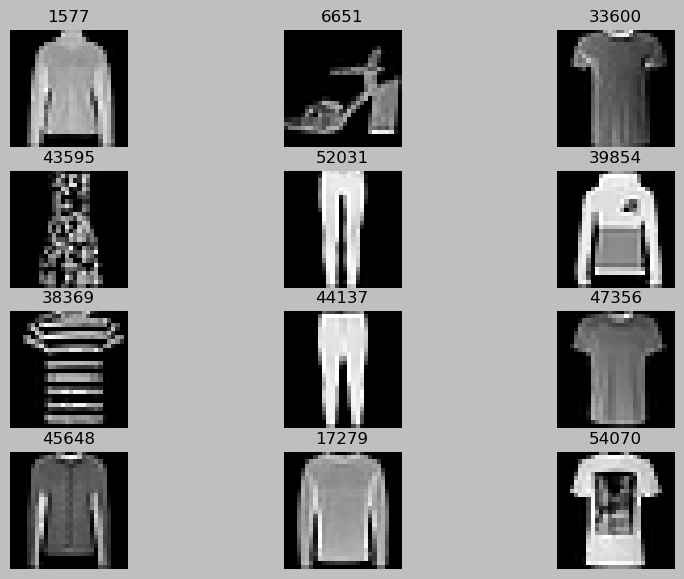

In [6]:
import matplotlib.pyplot as plt


def display_random_images(n = 9, rows = 3, columns = 3):
    plt.style.use('grayscale')
    fig = plt.figure(figsize=(10, 7)) 
    images = []

    for i in range(n):
        id =  random.randint(0,len(train_dataset))
        images.append(torch.Tensor.numpy(train_dataset[id][0][0]))
        fig.add_subplot(rows,columns,i + 1)
        plt.axis('off') 
        plt.title(id)
        plt.imshow(images[i])
    

    #display some images
    plt.show()


display_random_images(12,4,3)

## Create and train model

In [12]:
import torch.nn as nn
from torch.optim import Adam

class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var


class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat


class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var


model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


def loss_function(x, x_hat, mean, log_var):
    x_normalized = (x - x.min()) / (x.max() - x.min())

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x_normalized, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(-1, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    return overall_loss


In [13]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  279.5836496374165
	Epoch 2 	Average Loss:  263.31328141303214
	Epoch 3 	Average Loss:  260.33645287719116
	Epoch 4 	Average Loss:  258.62394501904214
	Epoch 5 	Average Loss:  257.2988581229132
	Epoch 6 	Average Loss:  256.6561483657659
	Epoch 7 	Average Loss:  255.68589820925501
	Epoch 8 	Average Loss:  255.1184911049666
	Epoch 9 	Average Loss:  254.70962717810934
	Epoch 10 	Average Loss:  254.21041462333056
	Epoch 11 	Average Loss:  253.84298156432595
	Epoch 12 	Average Loss:  253.39841327342447
	Epoch 13 	Average Loss:  253.06183502452004
	Epoch 14 	Average Loss:  252.7471315147642
	Epoch 15 	Average Loss:  252.47413615791945
	Epoch 16 	Average Loss:  252.2286587672162
	Epoch 17 	Average Loss:  251.95267705290067
	Epoch 18 	Average Loss:  251.78734414127712
	Epoch 19 	Average Loss:  251.6418301335559
	Epoch 20 	Average Loss:  251.22338888381677
	Epoch 21 	Average Loss:  251.03283936769617
	Epoch 22 	Average Loss:  250.775094069543
	Epoch 23 	Average Loss:  25

14850549.873046875

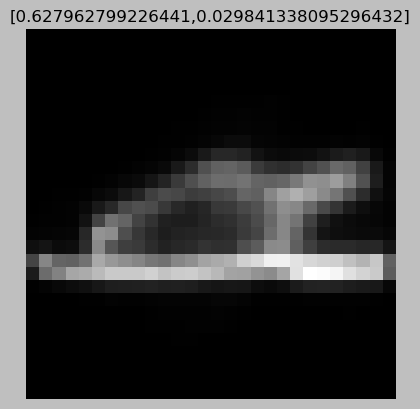

In [20]:
def generate(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate(np.random.rand(),np.random.rand())

##

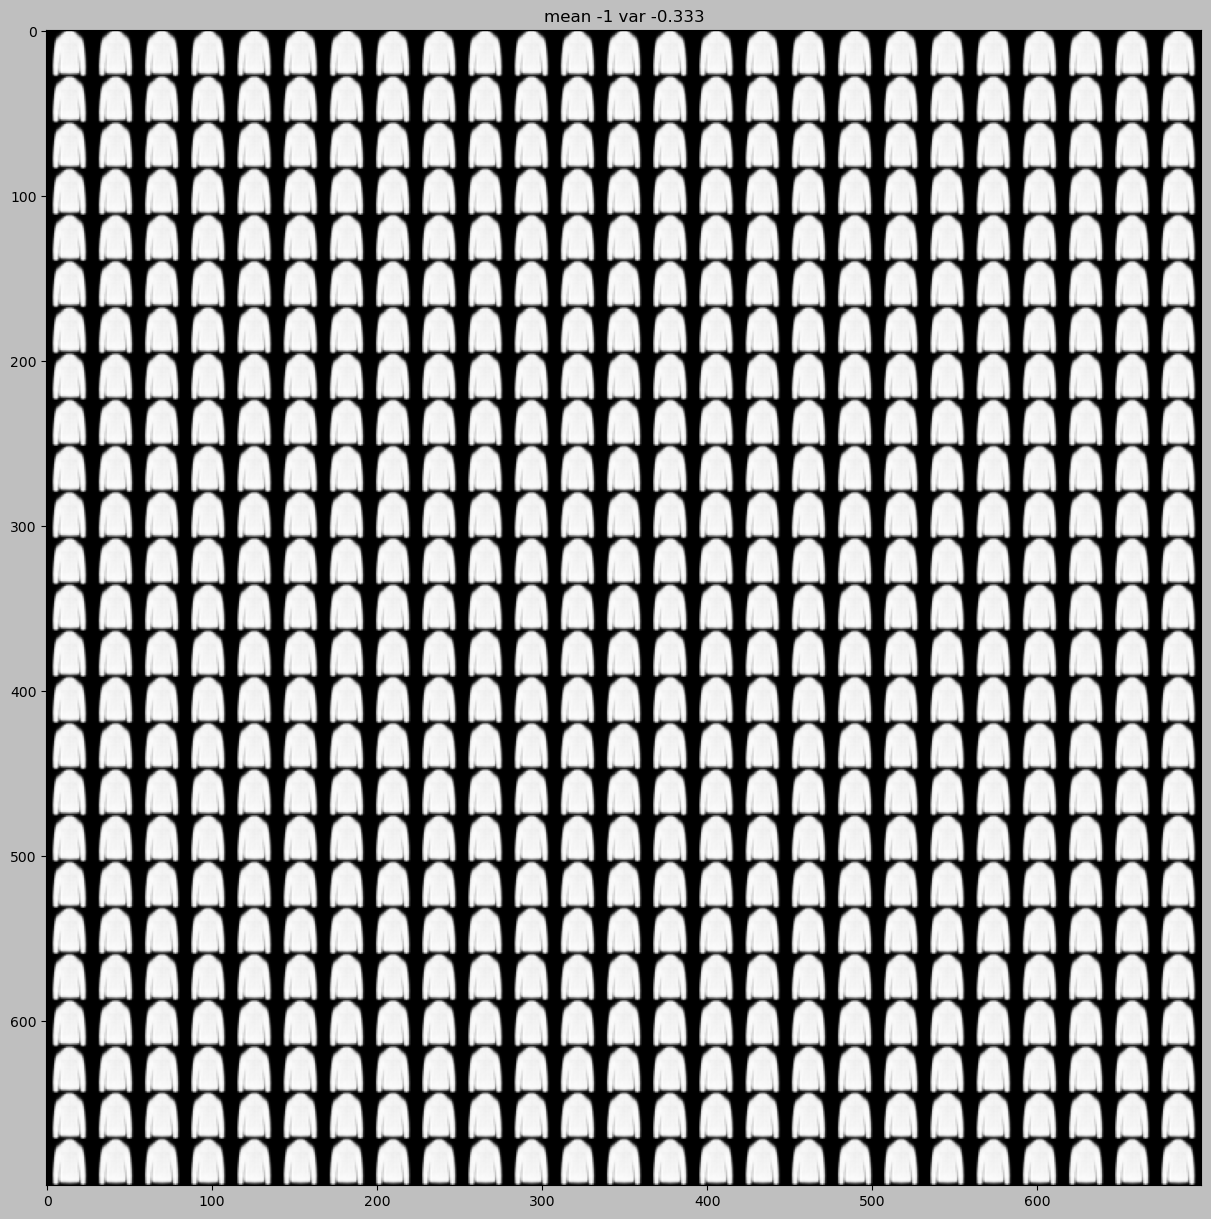

In [44]:
def plot_const_mean_var(model, mean, var , scale=5.0, n=25, img_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((img_size * n, img_size * n))

    for i in range(n):
        for j in range(n):
            z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(img_size, img_size)
            figure[i * img_size: (i + 1) * img_size, j * img_size: (j + 1) * img_size, ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('mean ' + str(mean) + " var " + str(var))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_const_mean_var(model, -1, -0.333 ,scale=1.0)

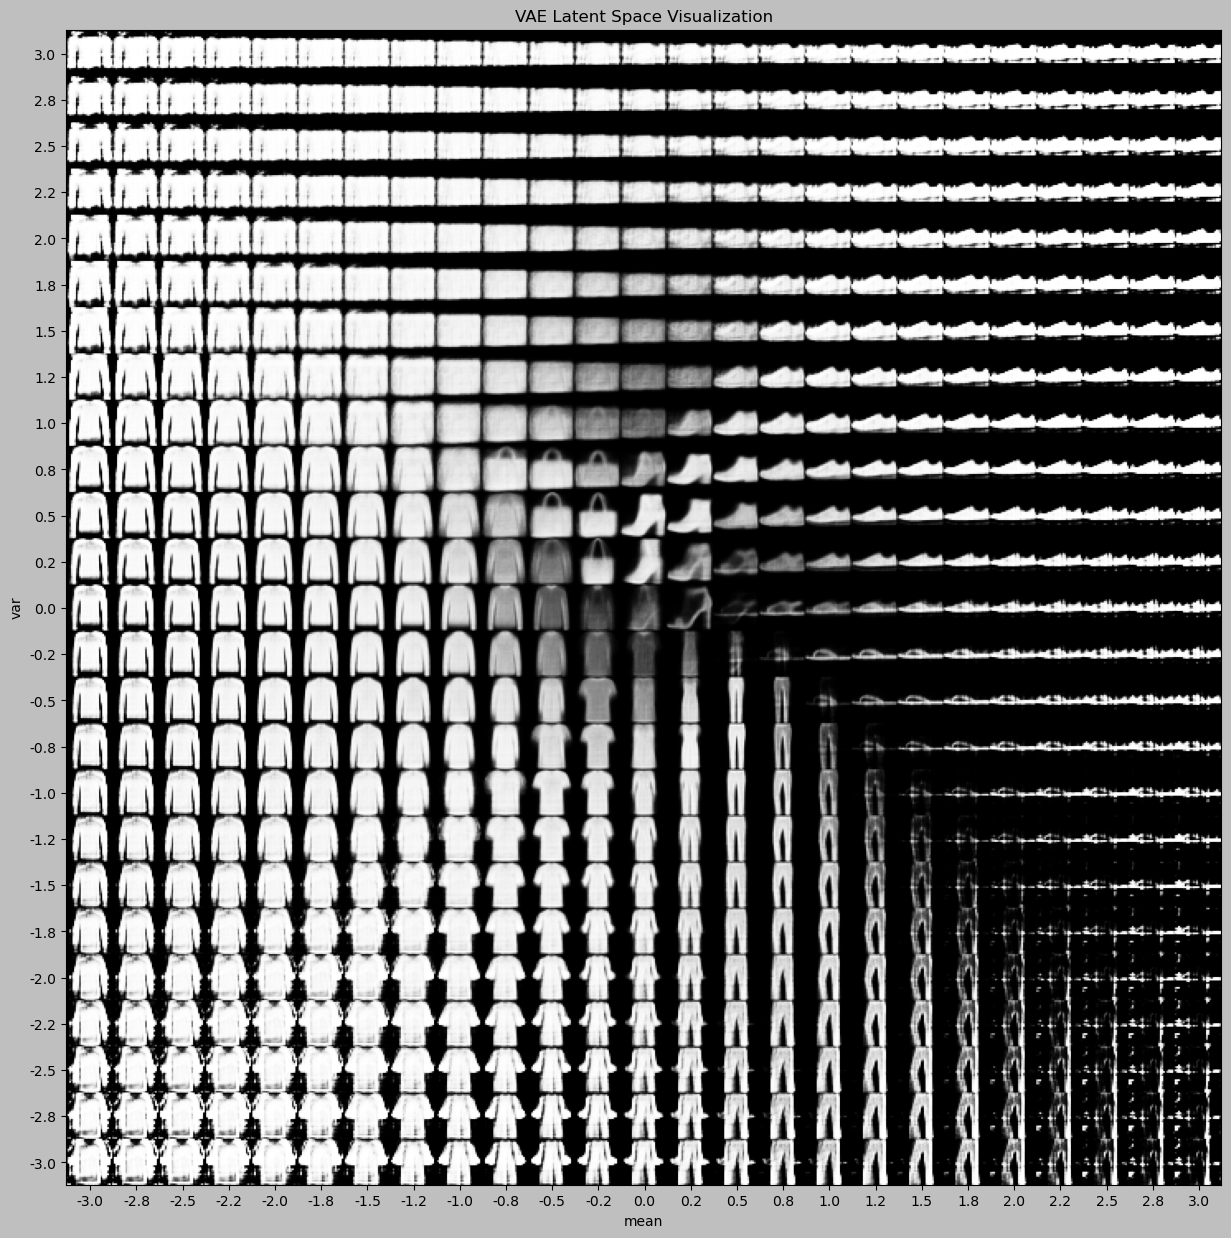

In [49]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size, ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean")
    plt.ylabel("var")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale=3)
